In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import sys

import pandas as pd
from rdkit import Che
import os
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from rdkit.Avalon import pyAvalonTools
from tqdm import tqdm

from sklearn.metrics import *
import matplotlib.pyplot as plt
import warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

In [ ]:
df_chembl = pd.read_csv("Dyslipidemia_CHEMBL1862_Tyrosine-protein_kinase_ABL - 1.csv")
df_chembl = df_chembl[['Smiles', 'Standard Type', 'Standard Value']]
df_bdb = pd.read_csv("Tyrosine_protein_kinase_ABL_BDB_Tyrosine_protein")
target_for_bdb = 'Ki (nM)'
target_for_chembl = 'Ki'
df_bdb = df_bdb[['Ligand SMILES', target_for_bdb]]
df_chembl = df_chembl.loc[df_chembl['Standard Type'] == target_for_chembl]
df_chembl = df_chembl.drop(['Standard Type'], axis=1)

In [ ]:
df_bdb = df_bdb.rename(columns={'Ligand SMILES': 'Smiles', target_for_bdb: 'Standard Value'})

In [ ]:
df = pd.concat([df_chembl, df_bdb], ignore_index=True)
df['Standard Value'] = df['Standard Value'].replace(to_replace='>', value='', regex=True)
df['Standard Value']= df['Standard Value'].replace(to_replace='<', value='', regex=True)
df['Standard Value'] = pd.to_numeric(df['Standard Value'])
df = df.dropna()
df

,Smiles,Standard Value
0,OB(O)c1ccccc1,470000.00
1,CC(C)(C)[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cc...,4.20
2,CO[C@H](C)[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@H](...,10.10
3,C[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cccc(c2)C...,2.10
4,COc1ccc(C[C@@H]2NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)...,80.70
...,...,...
604,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.01
605,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.01
606,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.00
607,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.00


In [ ]:
q3 = df['Standard Value'].quantile(0.75)
df = df[df['Standard Value'] <= q3]
df['Standard Value'].describe()

count   102.00
mean      2.77
std       3.37
min       0.00
25%       0.13
50%       1.40
75%       4.20
max      11.00
Name: Standard Value, dtype: float64

In [ ]:
def safe_canon_smiles(smiles):
    try:
        return Chem.CanonSmiles(smiles)
    except Exception as e:
        print(f"Bad Smiles: {smiles}")
        return None
df['Smiles'] = df['Smiles'].astype('string')
df['Canonical Smiles'] = df.Smiles.apply(safe_canon_smiles)
df

,Smiles,Standard Value,Canonical Smiles
1,CC(C)(C)[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cc...,4.20,CC(C)(C)[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cc...
2,CO[C@H](C)[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@H](...,10.10,CO[C@H](C)[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@H](...
3,C[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cccc(c2)C...,2.10,C[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cccc(c2)C...
5,C[C@@]12CCCN1C(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@...,10.70,C[C@@]12CCCN1C(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@...
6,COc1ccc(C[C@@H]2NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)...,3.90,COc1ccc(C[C@@H]2NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)...
...,...,...,...
604,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.01,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...
605,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.01,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...
606,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.00,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...
607,COc1ccc(C[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H]3[C@@...,0.00,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...


In [ ]:
df.replace('None', pd.NA, inplace=True)
df.dropna(inplace=True)
df.drop(['Smiles'], axis=1, inplace=True)
df

,Standard Value,Canonical Smiles
1,4.20,CC(C)(C)[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cc...
2,10.10,CO[C@H](C)[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@H](...
3,2.10,C[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cccc(c2)C...
5,10.70,C[C@@]12CCCN1C(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@...
6,3.90,COc1ccc(C[C@@H]2NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)...
...,...,...
604,0.01,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...
605,0.01,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...
606,0.00,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...
607,0.00,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...


In [ ]:
print(df.duplicated(subset='Canonical Smiles').sum())
df.drop_duplicates(inplace=True, keep = 'first', subset='Canonical Smiles')
df

66


,Standard Value,Canonical Smiles
1,4.20,CC(C)(C)[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cc...
2,10.10,CO[C@H](C)[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@H](...
3,2.10,C[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cccc(c2)C...
5,10.70,C[C@@]12CCCN1C(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@...
6,3.90,COc1ccc(C[C@@H]2NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)...
11,11.00,C[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cc(F)cc(c...
14,1.50,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...
15,10.60,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)OC)NC(=O)...
17,9.40,COCCOCCOCCOCCC(=O)NCCCC[C@@H]1NC(=O)CCSCc2cccc...
19,0.00,COc1ccc(C[C@@H]2NC(=O)[C@H]([C@@H](C)O)NC(=O)[...


In [ ]:
def get_all_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    mol_descriptors = []
    for mol in tqdm(mols):
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)
    return mol_descriptors, desc_names

In [ ]:
print(df['Canonical Smiles'].describe())
mol_descriptors, descriptors_names = get_all_descriptors(df['Canonical Smiles'].tolist()) #вызов функции для подсчета дескрипторов
df[[*descriptors_names]] = mol_descriptors # добавление дескрипторов в датасет

count                                                    36
unique                                                   36
top       CC(C)(C)[C@H]1NC(=O)[C@H](CCCCN)NC(=O)CCSCc2cc...
freq                                                      1
Name: Canonical Smiles, dtype: object


100%|██████████| 36/36 [03:37<00:00,  6.05s/it]


In [ ]:
def create_feature_importances(X, y):
    mutual_info = mutual_info_regression(X, y)
    threshold = 0.025
    selected_features = X.columns[mutual_info < threshold]
    X_selected = X[selected_features]
    print(f"Изначальное количество признаков: {X.shape[1]}")
    print(f"Количество отобранных признаков: {X_selected.shape[1]}")
    return X_selected

X = df.drop(['BCUT2D_MRLOW', 'BCUT2D_CHGHI', 'BCUT2D_MWHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MWLOW', 'Canonical Smiles', 'Standard Value'], axis=1)
y = df['Standard Value']

In [ ]:
y = np.log(y)

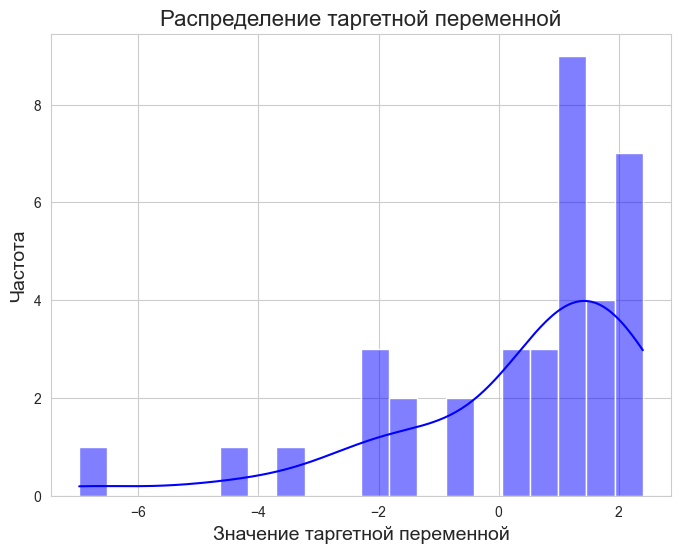

In [ ]:
# Преобразуем данные в Pandas Series
import seaborn as sns
target_series = pd.Series(y)

# Построим график распределения
plt.figure(figsize=(8, 6))
sns.histplot(target_series, kde=True, color='blue', bins=20)

# Настройки графика
plt.title('Распределение таргетной переменной', fontsize=16)
plt.xlabel('Значение таргетной переменной', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Отображение графика
plt.show()

In [ ]:
X = create_feature_importances(X, y)

Изначальное количество признаков: 202
Количество отобранных признаков: 96


In [ ]:
X.reset_index(inplace=True, drop=True)

In [ ]:
def generate_AVfpts(data):
    Avalon_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
    return pd.DataFrame(np.array(Avalon_fpts))
Avalon_fpts = generate_AVfpts(df['Canonical Smiles'])
Avalon_fpts

100%|██████████| 36/36 [00:00<00:00, 108.99it/s]


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,1,1,0,1,1
1,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,1,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,...,1,1,1,0,0,1,1,1,1,1
3,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,1,1,0,1,1
4,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,1,1,0,1,1
5,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,1,1,0,1,1
6,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,0,1,0,1,1
7,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,0,1,0,1,1
8,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,1,1,0,1,1
9,1,1,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
X_new = pd.concat([X, Avalon_fpts], axis=1)
X_new.columns = X_new.columns.astype(str)

In [ ]:
X_new.to_csv('Parkinson_belok_X.csv')
y.to_csv('Parkinson_belok_y.csv')

,MinAbsEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,Chi0v,Ipc,PEOE_VSA1,PEOE_VSA4,...,502,503,504,505,506,507,508,509,510,511
0,1.00,1443.71,1355.01,1442.61,544.00,0.00,50.37,10915308244914133248956664207068450522703153819...,78.25,23.52,...,1,0,1,0,0,1,1,0,1,1
1,0.89,1390.65,1304.97,1389.59,524.00,0.00,48.42,24706761887288020744542493120916418608086064651...,78.21,23.52,...,1,0,1,0,0,1,1,0,1,1
2,0.94,1408.64,1323.97,1407.58,530.00,0.00,48.80,13588493309996213261588799568180335464478239208...,78.58,23.52,...,1,1,1,0,0,1,1,1,1,1
3,0.98,1677.92,1575.10,1676.70,636.00,0.00,57.71,10756189904346893947957073566518775583800711068...,108.22,23.52,...,1,0,1,0,0,1,1,0,1,1
4,0.92,1415.66,1330.99,1414.58,532.00,0.00,49.37,17731639469517336023931867137390027642167857193...,77.87,23.52,...,1,0,1,0,0,1,1,0,1,1
5,0.93,1408.64,1323.97,1407.58,530.00,0.00,48.80,13622410107463210788259417892999169200360724548...,78.58,23.52,...,1,0,1,0,0,1,1,0,1,1
6,0.91,1290.55,1209.91,1289.54,486.00,0.00,45.15,14955470497808281909752854704831100492805456118...,67.51,23.52,...,1,0,1,0,0,0,1,0,1,1
7,0.98,1318.61,1233.93,1317.57,498.00,0.00,46.15,27532597875004686944174140041417466656106359211...,66.73,23.52,...,1,0,1,0,0,0,1,0,1,1
8,0.98,1648.88,1549.09,1647.67,624.00,0.00,56.76,27643207457948077656235821123127794379534264103...,102.50,23.52,...,1,0,1,0,0,1,1,0,1,1
9,0.92,1611.95,1506.11,1610.73,612.00,0.00,56.16,82271202095207687497740369597597217836182609525...,85.38,23.52,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
y

1     1.44
2     2.31
3     0.74
5     2.37
6     1.36
11    2.40
14    0.41
15    2.36
17    2.24
19   -6.98
20    1.44
21   -0.80
22   -1.39
23    1.44
24    0.41
25    0.99
28   -2.05
30    0.77
32   -2.05
35    1.46
37   -0.73
39   -4.61
40   -3.30
42    2.25
43    1.03
44    2.10
47   -1.61
48    1.39
52    1.57
54   -2.05
55    0.81
56    1.47
57    0.31
59    1.54
66    1.39
67    1.84
Name: Standard Value, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
# y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1,1)))
x = pd.DataFrame(scaler.fit_transform(X_new))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)
def create_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    plt.plot(y_test, y_test, 'r')
    plt.scatter(y_test, y_pred)
    plt.show()
    print('RMSE:', rmse)
    print('MAE:', mae)
    print("R2:", r2)
    return model, rmse, mae, r2

In [ ]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
model, rmse, mae, r2 = create_model(CatBoostRegressor())

ImportError: cannot import name '_catboost' from partially initialized module 'catboost' (most likely due to a circular import) (/Users/deni/Desktop/PythonAllProjects/sber/venv/lib/python3.12/site-packages/catboost/__init__.py)